In this notebook I will extract the density of the taxa that might be in the active layer for a range of combinations of modeled backscatter responses 


In [51]:
import os
import numpy as np
import pandas as pd
from scipy import signal
from scipy import optimize
from scipy import linalg
from scipy.interpolate import UnivariateSpline
import matplotlib
import matplotlib.pyplot as plt
import array as arr
import seaborn as sns
import random
import pylab
import glob
from scipy import stats
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import datetime
import cartopy.crs as ccrs
import cartopy
#from uncertainties import unumpy


import sb_tools

%matplotlib inline

In [52]:
# median of scattering model resulsts
import inverse_method_funs_med as inv

# mean of scattering model results
#import inverse_method_funs as inv

In [53]:
sns.set_theme(style="whitegrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

savefigs_path= 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/JASA_manuscript/2021-05 v JASA_LaTeXPackage_2/'
savefigjpg_path= 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/Figs/'

# Read scattering models
Import species backscattering cross section matrix

In [54]:
# Sigmabs from ZooScatR model runs + viscous elactic model for mean of fish larvae model by ve=True)
fname_sim = '../ZooScatStuff/my_simplified_data.feather'

#90 percent confidence intervals
specs, freqs_sim, sig_bs_mean, ci_boot = inv.read_scatteringmodelsimulations(fname_sim, nsim=1000, ve=True, percentiles=(2.5,97.5))

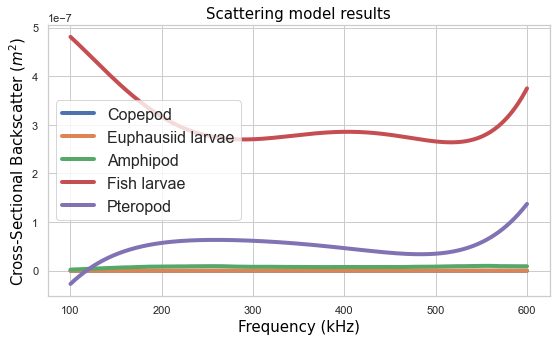

In [55]:
fig=plt.figure(figsize=(9, 5),facecolor='w', edgecolor='k')
plt.plot(freqs_sim,sig_bs_mean, linewidth=4)
plt.legend(specs, fontsize=16)
plt.ylabel('Cross-Sectional Backscatter ($m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Scattering model results', title_font);

# Resample to line up output and input

In [57]:
fname_EV = glob.glob('F:/GLIDER2018/Echosounder/Flaket_SSL/ssl_GLIDER2018*Widebandfrequencyexport*.csv')

sv_all = np.zeros((1001,0))
times = np.zeros((0))

freqs_EV, sv_out_no, times_out_no = inv.read_widebandfrequencyresponse(fname_EV[0])
sv_all = np.zeros((len(freqs_EV),0))
times = np.zeros((0))

In [58]:
sigbs_mean = np.zeros([len(freqs_EV),len(specs)])
ci_boot0 = np.zeros([len(freqs_EV),len(specs)])
ci_boot1 = np.zeros([len(freqs_EV),len(specs)])

for ind_spec in range(0,len(specs)):
    sigbs_mean[:,ind_spec] = np.interp(freqs_EV, freqs_sim, sig_bs_mean[:,ind_spec])
    ci_boot0[:,ind_spec] = np.interp(freqs_EV, freqs_sim, ci_boot[0,:,ind_spec])
    ci_boot1[:,ind_spec] = np.interp(freqs_EV, freqs_sim, ci_boot[1,:,ind_spec])

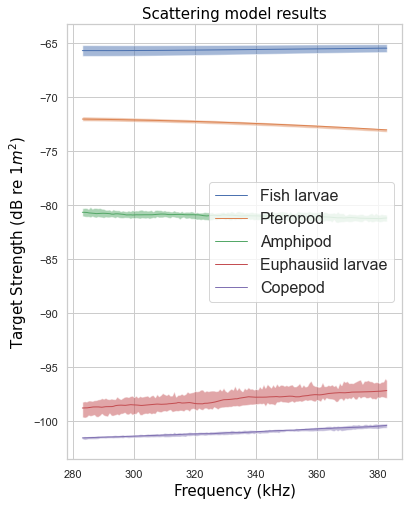

In [59]:
fig=plt.figure(figsize=(6, 8),facecolor='w', edgecolor='k')
order=[3,4,2,1,0]
for ind in [3,4,2,1,0]:
    # Calculate log ci S(TS) = 10*0.434(S(sigbs)/sigbs)
    logci_0 = 10*np.log10(sigbs_mean[:,ind]) - (10*(0.434*(sigbs_mean[:,ind]-ci_boot0[:,ind])/sigbs_mean[:,ind]))
    logci_1 = 10*np.log10(sigbs_mean[:,ind]) + 10*(0.434*(ci_boot1[:,ind]-sigbs_mean[:,ind])/sigbs_mean[:,ind])
    
    plt.plot(freqs_EV[:],10*np.log10(sigbs_mean[:,ind]), linewidth=1, label=specs[ind])
    plt.fill_between(freqs_EV[:],logci_0,logci_1, alpha=0.5)
    
plt.legend(fontsize=16, loc='right')
plt.ylabel('Target Strength (dB re $1m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Scattering model results', title_font);

# Load density estimate data

In [60]:
data = pd.read_feather('SSL_density_median.feather')
data_inv = data[data.source=='Inverse']

In [61]:
inverse_density = data_inv.groupby(['species','datetime']).mean()['density']
inverse = inverse_density.reset_index(1)
inv_spec = inverse.index.unique()

In [62]:
density_values = np.reshape(inverse_density.values,(5,70))
density_mean = np.mean(density_values, axis=1)
density_std = np.std(density_values, axis=1)

In [63]:
density_mean

array([1.89719768e+01, 2.97094600e+03, 4.76516453e+02, 6.64440792e-01,
       2.10089960e+00])

In [64]:
density_std

array([1.05767969e+01, 1.84028619e+03, 3.01003541e+02, 5.26853947e-01,
       1.50867859e+00])

# Inverse method -  Sensitivity analysis
Calculate mean predicted density for each active layer


In [65]:
# Make matrix with ci_min, mean and ci_max for all species
sensitvity_matrix = [ci_boot0, sigbs_mean, ci_boot1]

In [66]:
fname_EV = glob.glob('F:/GLIDER2018/Echosounder/Flaket_SSL/ssl_GLIDER2018*Widebandfrequencyexport*.csv')
nfiles = len(fname_EV)

sv_all_q = np.zeros((3,len(freqs_EV), nfiles))


for ind in np.arange(nfiles):
    freqs_EV, sv_out, times_out = inv.read_widebandfrequencyresponse(fname_EV[ind])

    sv_all_q[:,:,ind] = np.percentile(sv_out, (5,50,95), axis=1)
        

In [67]:
# sensitivitiy analysis iterations

n_iterations = 500

sensitvity_sig = np.zeros((np.shape(sigbs_mean)))
sv_all = np.zeros((len(freqs_EV),0))
times = np.zeros((0))
density = np.zeros((n_iterations, 5, nfiles))

for iterate in np.arange(n_iterations):
    # For each species select random q25, q50 or q75
    for ind in range(len(specs)):
        rand_ind = np.random.randint(0,2)
        sensitvity_sig[:,ind] = sensitvity_matrix[rand_ind][:,ind]
    # For each file select random q25, q50, q75.
    rand_svq = np.random.randint(0,2)
    sensitivity_sv = sv_all_q[rand_svq,:,:]
        
        
    for ind in np.arange(nfiles):
        times = np.append(times, times_out[0])
        
        d = optimize.lsq_linear(sensitvity_sig, sensitivity_sv[:,ind], bounds=(0,np.inf))
        density[iterate,:,ind] = d.x

In [68]:
q_5 = np.percentile(density,5,axis=0)
q_95 = np.percentile(density,95,axis=0)
q_50 = np.percentile(density,50,axis=0)

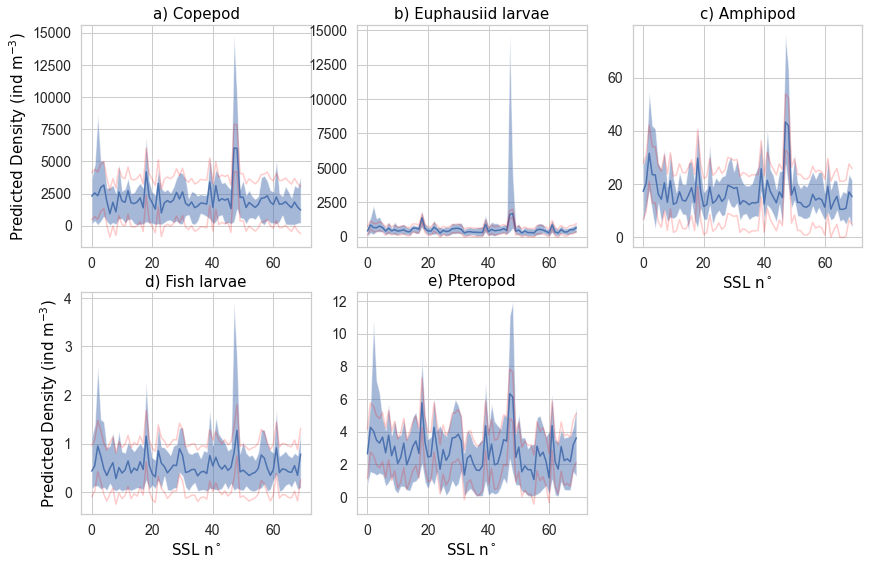

In [69]:
fig, axes = plt.subplots(2, 3, figsize=(14, 9))
axes = axes.flatten()
title_letter= ['a) ','b) ','c) ','d) ','e) ','f) ']

for ind in range(0,len(specs)):
    #plt.plot(density[:,ind,:].T)
    ind_inv = np.where(inv_spec==specs[ind])[0][0]
    axes[ind].plot(np.arange(0,len(fname_EV)), q_50[ind,:])
    axes[ind].plot(np.arange(0,len(fname_EV)), q_50[ind,:]+density_std[ind_inv], '-', c='red',alpha=0.2)
    axes[ind].plot(np.arange(0,len(fname_EV)), q_50[ind,:]-density_std[ind_inv], '-',c='red',alpha=0.2)
    axes[ind].fill_between(np.arange(0,len(fname_EV)),q_5[ind,:],q_95[ind,:], alpha=0.5)
    axes[ind].set_title(title_letter[ind]+specs[ind], title_font)
    axes[ind].tick_params(labelsize=14)

axes[0].set_ylabel('Predicted Density (ind m$^{-3}$)', axis_font);
axes[3].set_ylabel('Predicted Density (ind m$^{-3}$)', axis_font);

axes[2].set_xlabel('SSL n$^\circ$', axis_font);
axes[3].set_xlabel('SSL n$^\circ$', axis_font);
axes[4].set_xlabel('SSL n$^\circ$', axis_font);

axes[5].remove()


axes[0].set_rasterized(True)
axes[1].set_rasterized(True)
axes[2].set_rasterized(True)
axes[3].set_rasterized(True)
axes[4].set_rasterized(True)
axes[5].set_rasterized(True)
plt.savefig(savefigs_path+'sensitivityanalysis.eps', format='eps', dpi = 300, facecolor='w', bbox_inches='tight')
plt.savefig(savefigjpg_path+'sensitivityanalysis.jpg', format='jpg', dpi = 300, facecolor='w', bbox_inches='tight')

In [70]:
q_25 = np.percentile(density,25,axis=0)
q_75 = np.percentile(density,75,axis=0)

In [71]:
np.mean(q_75-q_25, axis=1)/np.mean(q_50,axis=1)

array([0.81135338, 0.58202532, 0.44073344, 0.86477862, 0.81559158])

## Load lat/lon

In [72]:
SB_env_df = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SB_env_tromsøflaket2018.xlsx',header=0, engine="openpyxl")


In [73]:
SB_env_times = SB_env_df.set_index(['datetime'])

In [74]:
index = []
for ind in range(len(times)):
    ind_index = SB_env_times.index.get_loc(times[ind], method="nearest")
    index = np.append(index, ind_index)

# Make dataframe with median

In [75]:
data = pd.DataFrame()

for specs_ind in range(len(specs)):
    for ind in range(nfiles):
            SB_env_ind = SB_env_times.index.get_loc(times[ind], method="nearest")
            data = data.append({'lat': SB_env_df['latitude (deg)'][SB_env_ind],
                                'lon': SB_env_df['longitude (deg)'][SB_env_ind],
                                'datetime': times[ind],
                                'density': q_50[specs_ind,ind],
                                'species': specs[specs_ind],                        
                                'source': 'Acoustics'}, 
                                'ignore_index=True')

## Add net data

In [76]:
SP_stations_df = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SeaPatchesStations.xlsx',header=0)
tucker_density = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/Tucker Trawl.xlsx', header=79)
multinet_density = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SP_Multinet.xlsx')

In [77]:
#Station 7 from Tucker Trawl
stn = 7
for stn_ind in range(7,18):
    for ind_spec in [0,1,2,3,5]:
        data = data.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                            'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                            'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                            'density': tucker_density['Station ' + str(stn_ind)][ind_spec],
                            'species': tucker_density['Species'][ind_spec],
                            'source': 'TuckerTrawl'}, 
                            'ignore_index=True')
        data = data.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                            'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                            'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                            'density': multinet_density['Stn ' + str(stn_ind)][ind_spec],
                            'species': multinet_density['Species'][ind_spec],
                            'source': 'Multinet'}, 
                            'ignore_index=True')

In [78]:
## Add log of data as column
data['log_density']=np.log10(data.density+1)
data['log_density'][np.isnan(data['log_density'])]==0


Series([], Name: log_density, dtype: bool)

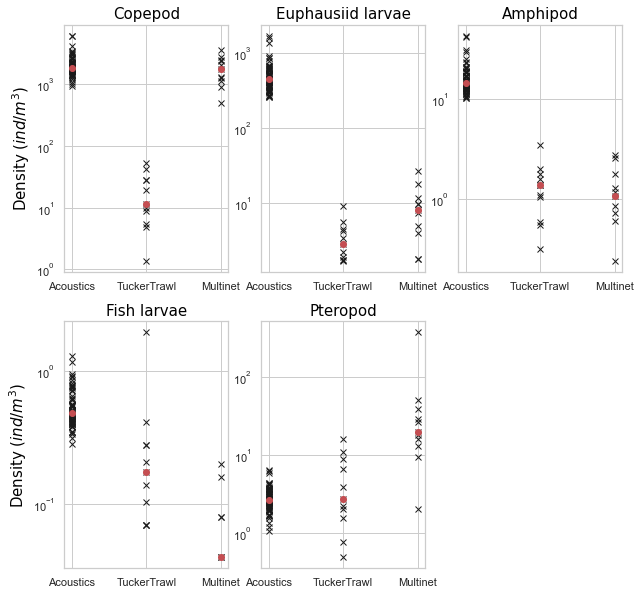

In [79]:
fig = plt.figure(figsize=(10,10))
for ind_spec in range(len(specs)):
    ax = plt.subplot(2,3,ind_spec+1)
    ax.semilogy(data.source[data.species==specs[ind_spec]],data.density[data.species==specs[ind_spec]], 'kx')
    ax.semilogy(data[data.species==specs[ind_spec]].groupby('source').median().index,data[data.species==specs[ind_spec]].groupby('source').median()['density'], 'r.', markersize=12)
    ax.set_title(specs[ind_spec], title_font)
    if ind_spec==0:
        ax.set_ylabel('Density ($ind/m^3$)', axis_font);
    if ind_spec==3:
        ax.set_ylabel('Density ($ind/m^3$)', axis_font);


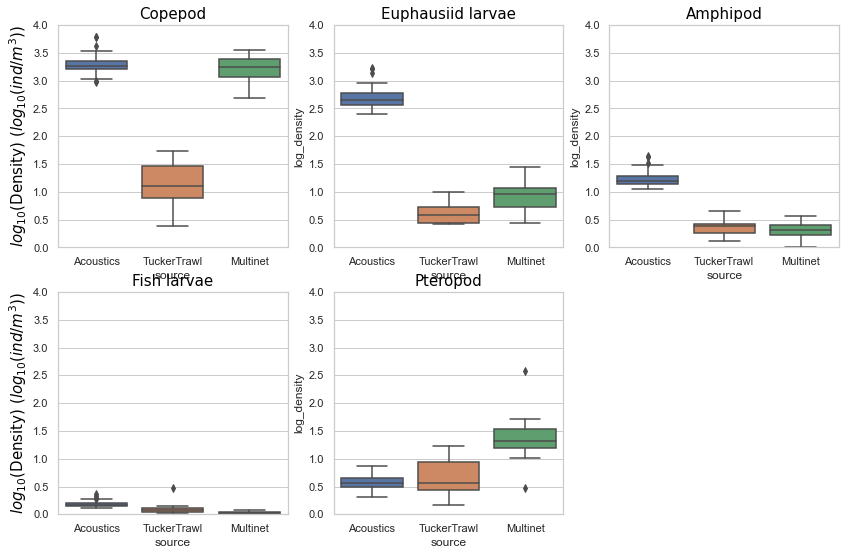

In [80]:
fig = plt.figure(figsize=(14,9))
for ind_spec in range(len(specs)):
    ax = plt.subplot(2,3,ind_spec+1)
    axplot = sns.boxplot(data = data[data.species==specs[ind_spec]], x='source', y='log_density')
    ax.set_title(specs[ind_spec], title_font)
    ax.set_ylim([0,4])
    if ind_spec==0:
        ax.set_ylabel('$log_{10}$(Density) ($log_{10}(ind/m^3)$)', axis_font);
    if ind_spec==3:
        ax.set_ylabel('$log_{10}$(Density) ($log_{10}(ind/m^3)$)', axis_font);

Plotted median of sensitity test

In [81]:
len(fname_EV)

70